In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import lingam

from graphviz import Digraph
from lingam.utils import make_dot
from IPython.display import Image, display, Markdown
import matplotlib.dates as mdates
from pyvis.network import Network

In [6]:
# Edges
df_edges_plant = pd.read_csv("../data/SupplyGraph/Edges/Edges (Plant).csv")
df_edges_product_group = pd.read_csv("../data/SupplyGraph/Edges/Edges (Product Group).csv")
df_edges_product_subgroup = pd.read_csv("../data/SupplyGraph/Edges/Edges (Product Sub-Group).csv")
df_edges_storage_location = pd.read_csv("../data/SupplyGraph/Edges/Edges (Storage Location).csv")

# Nodes
df_nodes_productgroup_and_subgroup = pd.read_csv("../data/SupplyGraph/Nodes/Node Types (Product Group and Subgroup).csv")
df_nodes_plant_and_storage = pd.read_csv("../data/SupplyGraph/Nodes/Nodes Type (Plant & Storage).csv")
df_nodes = pd.read_csv("../data/SupplyGraph/Nodes/Nodes.csv")
df_nodes_index = pd.read_csv("../data/SupplyGraph/Nodes/NodesIndex.csv")

# Temporal
df_delivery_to_distributor = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Delivery To distributor.csv")
df_factory_issue = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Factory Issue.csv")
df_production = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Production.csv")
df_sales_order = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Sales Order.csv")

In [9]:
from IPython.display import IFrame, display


def get_edges_by_node1(node1_value, df=None, case_sensitive=True):
    """
    Return rows where 'node1' equals the provided value(s).

    Args:
        node1_value: str or iterable of str - one node value or list of node values to match.
        df: pandas.DataFrame - dataframe to search (defaults to df_edges_plant).
        case_sensitive: bool - if False and node1_value is str, compare case-insensitively.

    Returns:
        pandas.DataFrame: filtered rows (copy).
    """
    if df is None:
        df = df_edges_plant

    # Normalize input
    if isinstance(node1_value, (list, tuple, set, np.ndarray)):
        vals = list(node1_value)
        if not case_sensitive:
            vals = [str(v).lower() for v in vals]
            mask = df['node1'].astype(str).str.lower().isin(vals)
        else:
            mask = df['node1'].isin(vals)
    else:
        # single value
        if not case_sensitive and isinstance(node1_value, str):
            mask = df['node1'].astype(str).str.lower() == node1_value.lower()
        else:
            mask = df['node1'] == node1_value

    return df.loc[mask].copy()

# get_edges_by_node1(node1_value="AT5X5K")

def visualize_edges_for_node(node1_value=None, show_types=('plant','group','subgroup','storage'), notebook=True):
    """
    Interactive network visualization showing edges around a product.
    Uses df_edges_plant, df_edges_product_group, df_edges_product_subgroup and df_edges_storage_location.
    """
    # choose default product if not provided
    node1_value = node1_value or globals().get('product_to_query', df_nodes['Node'].iat[0])

    # collect edges
    edge_frames = []
    if 'plant' in show_types and 'df_edges_plant' in globals():
        ef = get_edges_by_node1(node1_value, df=df_edges_plant)
        if not ef.empty:
            ef = ef.assign(edge_type='plant')
            edge_frames.append(ef)
    if 'group' in show_types and 'df_edges_product_group' in globals():
        ef = get_edges_by_node1(node1_value, df=df_edges_product_group)
        if not ef.empty:
            ef = ef.assign(edge_type='product_group')
            edge_frames.append(ef)
    if 'subgroup' in show_types and 'df_edges_product_subgroup' in globals():
        ef = get_edges_by_node1(node1_value, df=df_edges_product_subgroup)
        if not ef.empty:
            ef = ef.assign(edge_type='product_subgroup')
            edge_frames.append(ef)
    if 'storage' in show_types and 'df_edges_storage_location' in globals():
        # storage dataframe has Storage Location column
        ef = df_edges_storage_location[df_edges_storage_location['node1'] == node1_value].copy()
        if not ef.empty:
            ef = ef.assign(edge_type='storage')
            edge_frames.append(ef)

    if not edge_frames:
        print(f"No edges found for {node1_value} with types {show_types}")
        return None

    edges = pd.concat(edge_frames, ignore_index=True, sort=False)

    # Build networkx graph (undirected visualization)
    G = nx.Graph()
    # Node type mapping for visual styling
    def add_product(n):
        if n not in G:
            G.add_node(n, node_type='Product')
    for _, r in edges.iterrows():
        n1 = r['node1']
        n2 = r['node2']
        add_product(n1)
        add_product(n2)
        etype = r.get('edge_type', 'edge')
        # attach raw metadata when available; avoid duplicate edge_type kwarg
        meta = {k: v for k, v in r.items() if k not in ['node1', 'node2']}
        meta.pop('edge_type', None)        # FIX: remove duplicated key
        G.add_edge(n1, n2, edge_type=etype, **meta)
    # for _, r in edges.iterrows():
    #     n1 = r['node1']
    #     n2 = r['node2']
    #     add_product(n1)
    #     add_product(n2)
    #     etype = r.get('edge_type', 'edge')
    #     # attach raw metadata when available
    #     meta = {k: v for k, v in r.items() if k not in ['node1', 'node2']}
    #     G.add_edge(n1, n2, edge_type=etype, **meta)

    # Add explicit Group/SubGroup/Storage nodes for clearer semantics (optional)
    if 'product_group' in edges['edge_type'].unique() and 'df_edges_product_group' in globals():
        for _, r in edges[edges['edge_type']=='product_group'].iterrows():
            code = r.get('GroupCode', None)
            if pd.notna(code):
                gnode = f"Group:{code}"
                G.add_node(gnode, node_type='Group')
                G.add_edge(r['node1'], gnode, edge_type='belongs_to_group')
                G.add_edge(r['node2'], gnode, edge_type='belongs_to_group')

    if 'product_subgroup' in edges['edge_type'].unique() and 'df_edges_product_subgroup' in globals():
        for _, r in edges[edges['edge_type']=='product_subgroup'].iterrows():
            code = r.get('SubGroupCode', None)
            if pd.notna(code):
                sgnode = f"SubGroup:{code}"
                G.add_node(sgnode, node_type='Sub-Group')
                G.add_edge(r['node1'], sgnode, edge_type='belongs_to_subgroup')
                G.add_edge(r['node2'], sgnode, edge_type='belongs_to_subgroup')

    if 'storage' in edges['edge_type'].unique():
        for _, r in edges[edges['edge_type']=='storage'].iterrows():
            loc = r.get('Storage Location')
            if pd.notna(loc):
                snode = f"Storage:{int(loc)}"
                G.add_node(snode, node_type='Storage')
                G.add_edge(r['node1'], snode, edge_type='stored_at')

    color_map = {
        'Product': '#ff6b6b', 'Group': '#4ecdc4', 'Sub-Group': '#45b7d1',
        'Storage': '#f6a623', 'Plant': '#6bcbe0'
    }

    # Use pyvis interactive visualization (best in notebook)
    net = Network(notebook=notebook, height='700px', width='100%', bgcolor='#ffffff')
    net.force_atlas_2based()

    # small uniform size for ALL nodes
    small_node_size = 12

    # add nodes with uniform sizing (no variation by degree)
    for n in G.nodes():
        nt = G.nodes[n].get('node_type', 'Product')
        degree = G.degree(n)
        size = small_node_size
        color = color_map.get(nt, '#cccccc')
        net.add_node(n, label=n, title=f"{nt}<br>degree={degree}", color=color, size=size)

    # highlight the queried node: only change color, do not change size
    if node1_value in net.nodes:
        node = net.get_node(node1_value)
        if node:
            node['color'] = '#ffcc00'


    # # colors for node types
    # color_map = {
    #     'Product': '#ff6b6b', 'Group': '#4ecdc4', 'Sub-Group': '#45b7d1',
    #     'Storage': '#f6a623', 'Plant': '#6bcbe0'
    # }

    # # Use pyvis interactive visualization (best in notebook)
    # net = Network(notebook=notebook, height='700px', width='100%', bgcolor='#ffffff')
    # net.force_atlas_2based()

    # # add nodes with sizing by degree
    # for n in G.nodes():
    #     nt = G.nodes[n].get('node_type', 'Product')
    #     degree = G.degree(n)
    #     size = 15 + degree * 8
    #     color = color_map.get(nt, '#cccccc')
    #     net.add_node(n, label=n, title=f"{nt}<br>degree={degree}", color=color, size=size)

    # add edges with type in title
    for u, v, data in G.edges(data=True):
        title = data.get('edge_type', '')
        net.add_edge(u, v, title=title, weight=max(1, int(data.get('weight',1))))

    # # highlight the queried node
    # if node1_value in net.nodes:
    #     net.get_node(node1_value)['color'] = '#ffcc00'
    #     net.get_node(node1_value)['size'] = max(net.get_node(node1_value)['size'], 30)

    # present network in notebook
    out_file = f"node_edges_{node1_value}.html"
    net.show(out_file)
    # display in notebook
    try:
        display(IFrame(out_file, width='100%', height='700px'))
    except Exception:
        print(f"Saved interactive graph to {out_file}")

    return G, net

# Example usage
# Define the product to query before using it
product_to_query = "SOS005L04P"  # or any valid product from df_nodes
G, net = visualize_edges_for_node(node1_value=product_to_query, show_types=('plant','group','subgroup','storage'))

node_edges_SOS005L04P.html


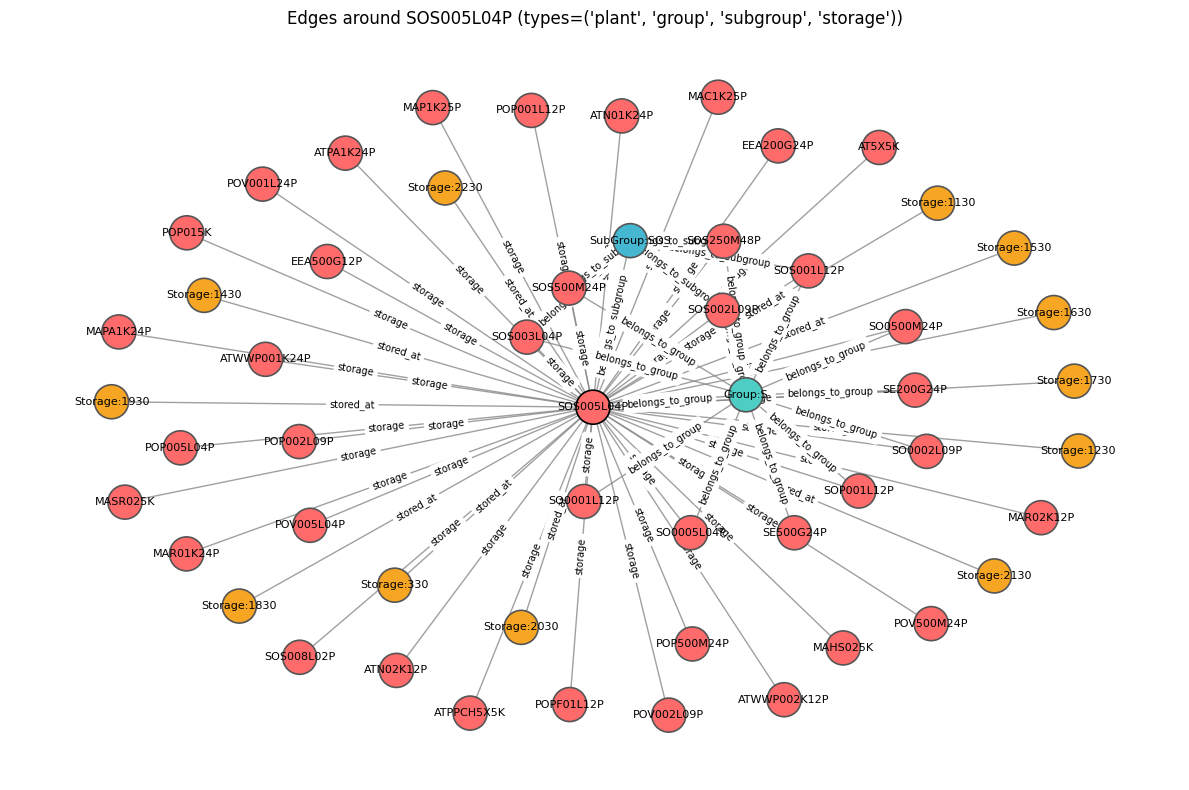

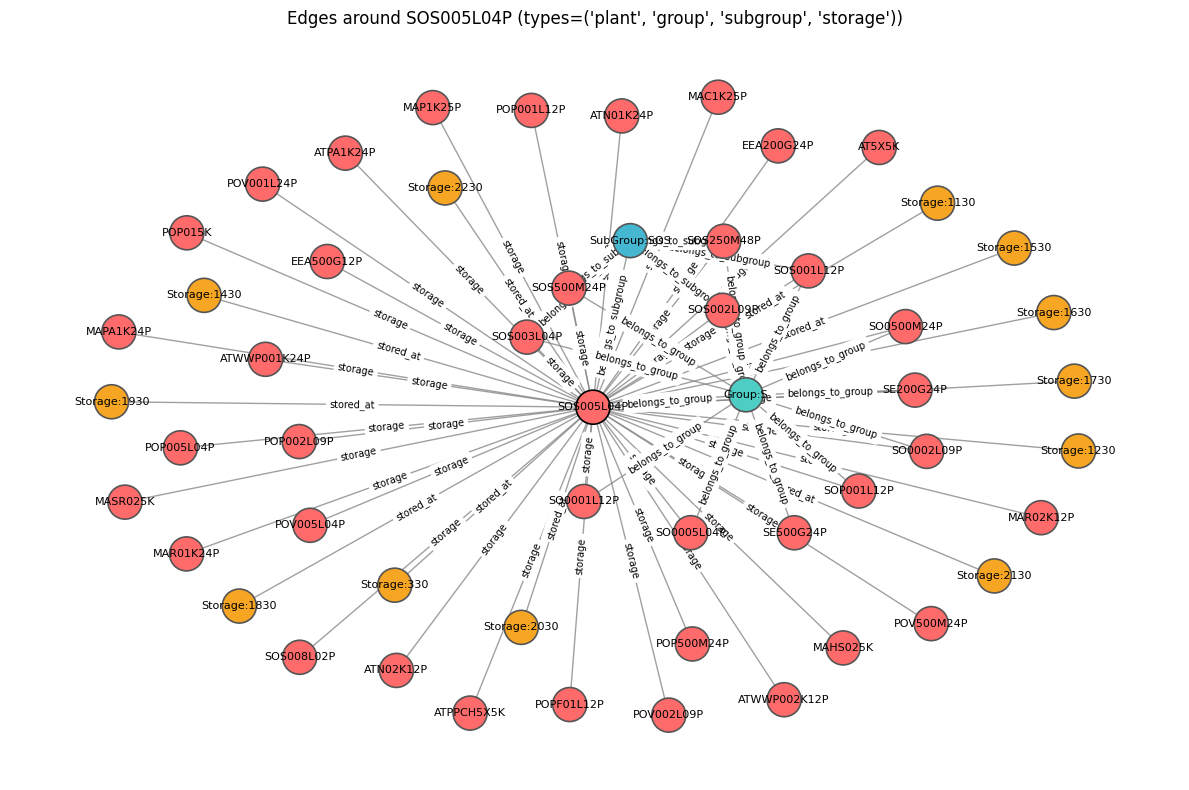

In [11]:
from IPython.display import display
import matplotlib.pyplot as plt

def visualize_edges_for_node(node1_value=None, show_types=('plant','group','subgroup','storage'), notebook=True, draw_edge_labels=True):
    """
    Interactive network visualization showing edges around a product using networkx+matplotlib.
    Returns (G, ax) where ax is the matplotlib Axes containing the plot.
    """
    node1_value = node1_value or globals().get('product_to_query', df_nodes['Node'].iat[0])

    # collect edges (same logic as before)
    edge_frames = []
    if 'plant' in show_types and 'df_edges_plant' in globals():
        ef = get_edges_by_node1(node1_value, df=df_edges_plant)
        if not ef.empty:
            ef = ef.assign(edge_type='plant')
            edge_frames.append(ef)
    if 'group' in show_types and 'df_edges_product_group' in globals():
        ef = get_edges_by_node1(node1_value, df=df_edges_product_group)
        if not ef.empty:
            ef = ef.assign(edge_type='product_group')
            edge_frames.append(ef)
    if 'subgroup' in show_types and 'df_edges_product_subgroup' in globals():
        ef = get_edges_by_node1(node1_value, df=df_edges_product_subgroup)
        if not ef.empty:
            ef = ef.assign(edge_type='product_subgroup')
            edge_frames.append(ef)
    if 'storage' in show_types and 'df_edges_storage_location' in globals():
        ef = df_edges_storage_location[df_edges_storage_location['node1'] == node1_value].copy()
        if not ef.empty:
            ef = ef.assign(edge_type='storage')
            edge_frames.append(ef)

    if not edge_frames:
        print(f"No edges found for {node1_value} with types {show_types}")
        return None, None

    edges = pd.concat(edge_frames, ignore_index=True, sort=False)

    # Build networkx graph (undirected visualization)
    G = nx.Graph()
    def add_product(n):
        if n not in G:
            G.add_node(n, node_type='Product')
    for _, r in edges.iterrows():
        n1 = r['node1']
        n2 = r['node2']
        add_product(n1); add_product(n2)
        etype = r.get('edge_type', 'edge')
        meta = {k: v for k, v in r.items() if k not in ['node1', 'node2']}
        meta.pop('edge_type', None)
        G.add_edge(n1, n2, edge_type=etype, **meta)

    # optional additional semantic nodes (groups, subgroups, storage)
    if 'product_group' in edges['edge_type'].unique() and 'df_edges_product_group' in globals():
        for _, r in edges[edges['edge_type']=='product_group'].iterrows():
            code = r.get('GroupCode', None)
            if pd.notna(code):
                gnode = f"Group:{code}"
                G.add_node(gnode, node_type='Group')
                G.add_edge(r['node1'], gnode, edge_type='belongs_to_group')
                G.add_edge(r['node2'], gnode, edge_type='belongs_to_group')

    if 'product_subgroup' in edges['edge_type'].unique() and 'df_edges_product_subgroup' in globals():
        for _, r in edges[edges['edge_type']=='product_subgroup'].iterrows():
            code = r.get('SubGroupCode', None)
            if pd.notna(code):
                sgnode = f"SubGroup:{code}"
                G.add_node(sgnode, node_type='Sub-Group')
                G.add_edge(r['node1'], sgnode, edge_type='belongs_to_subgroup')
                G.add_edge(r['node2'], sgnode, edge_type='belongs_to_subgroup')

    if 'storage' in edges['edge_type'].unique():
        for _, r in edges[edges['edge_type']=='storage'].iterrows():
            loc = r.get('Storage Location')
            if pd.notna(loc):
                snode = f"Storage:{int(loc)}"
                G.add_node(snode, node_type='Storage')
                G.add_edge(r['node1'], snode, edge_type='stored_at')

    color_map = {
        'Product': '#ff6b6b', 'Group': '#4ecdc4', 'Sub-Group': '#45b7d1',
        'Storage': '#f6a623', 'Plant': '#6bcbe0'
    }

    # layout and drawing
    plt.figure(figsize=(12, 8))
    # deterministic layout; use spring for connected graph
    pos = nx.spring_layout(G, seed=42, k=0.3)

    # prepare node colors and sizes
    small_node_size = 600  # matplotlib uses area; tune as needed
    node_colors = []
    for n in G.nodes():
        nt = G.nodes[n].get('node_type', 'Product')
        node_colors.append(color_map.get(nt, '#cccccc'))

    # highlight queried node: add a border color
    node_edge_colors = ['#000000' if n == node1_value else '#555555' for n in G.nodes()]

    # draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=small_node_size, edgecolors=node_edge_colors, linewidths=1.2)
    nx.draw_networkx_labels(G, pos, font_size=8)

    # draw edges with weight scaling and type annotations
    edge_weights = []
    for u, v, data in G.edges(data=True):
        w = int(data.get('weight', 1))
        edge_weights.append(max(1.0, w * 0.8))

    # draw the edges
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.8, edge_color='#888888')

    # show edge types as labels if enabled
    if draw_edge_labels:
        edge_labels = { (u,v): data.get('edge_type','') for u,v,data in G.edges(data=True) }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"Edges around {node1_value} (types={show_types})")
    plt.axis('off')
    plt.tight_layout()
    ax = plt.gca()
    display(ax.figure)   # show in notebook

    # return graph and axis so caller can inspect or further modify
    return G, ax

product_to_query = "SOS005L04P" 
G, net = visualize_edges_for_node(node1_value=product_to_query, show_types=('plant','group','subgroup','storage'))

In [52]:
df_edges_plant

,Plant,node1,node2
0,1901,ATWWP001K24P,ATN01K24P
1,1903,AT5X5K,ATN01K24P
2,1903,AT5X5K,MAR01K24P
3,1903,AT5X5K,SE500G24P
4,1903,AT5X5K,MASR025K
...,...,...,...
1642,2122,POP500M24P,POP002L09P
1643,2122,POP500M24P,POP001L12P
1644,2122,SOS008L02P,POP002L09P
1645,2122,SOS008L02P,POP001L12P


In [ ]:
def get_edges_by_node1(node1_value, df=None, case_sensitive=True):
    """
    Return rows where 'node1' equals the provided value(s).

    Args:
        node1_value: str or iterable of str - one node value or list of node values to match.
        df: pandas.DataFrame - dataframe to search (defaults to df_edges_plant).
        case_sensitive: bool - if False and node1_value is str, compare case-insensitively.

    Returns:
        pandas.DataFrame: filtered rows (copy).
    """
    if df is None:
        df = df_edges_plant

    # Normalize input
    if isinstance(node1_value, (list, tuple, set, np.ndarray)):
        vals = list(node1_value)
        if not case_sensitive:
            vals = [str(v).lower() for v in vals]
            mask = df['node1'].astype(str).str.lower().isin(vals)
        else:
            mask = df['node1'].isin(vals)
    else:
        # single value
        if not case_sensitive and isinstance(node1_value, str):
            mask = df['node1'].astype(str).str.lower() == node1_value.lower()
        else:
            mask = df['node1'] == node1_value

    return df.loc[mask].copy()


def visualize_edges_for_node(node1_value=None, show_types=('plant','group','subgroup','storage'), notebook=True, draw_edge_labels=True, node_size=600, node_font_size=8, edge_label_font_size=7):
    """
    Interactive network visualization showing edges around a product using networkx+matplotlib.
    Returns (G, ax) where ax is the matplotlib Axes containing the plot.
    
    Args:
        node1_value: Product node to visualize (str or None)
        show_types: Tuple of edge types to include ('plant','group','subgroup','storage')
        notebook: bool - whether running in notebook (legacy parameter)
        draw_edge_labels: bool - whether to show edge type labels
        node_size: int - size of nodes (default 600)
        node_font_size: int - font size for node labels (default 8)
        edge_label_font_size: int - font size for edge labels (default 7)
    
    Returns:
        Tuple of (networkx.Graph, matplotlib.axes.Axes)
    """
    node1_value = node1_value or globals().get('product_to_query', df_nodes['Node'].iat[0])

    # collect edges (same logic as before)
    edge_frames = []
    if 'plant' in show_types and 'df_edges_plant' in globals():
        ef = get_edges_by_node1(node1_value, df=df_edges_plant)
        if not ef.empty:
            ef = ef.assign(edge_type='plant')
            edge_frames.append(ef)
    if 'group' in show_types and 'df_edges_product_group' in globals():
        ef = get_edges_by_node1(node1_value, df=df_edges_product_group)
        if not ef.empty:
            ef = ef.assign(edge_type='product_group')
            edge_frames.append(ef)
    if 'subgroup' in show_types and 'df_edges_product_subgroup' in globals():
        ef = get_edges_by_node1(node1_value, df=df_edges_product_subgroup)
        if not ef.empty:
            ef = ef.assign(edge_type='product_subgroup')
            edge_frames.append(ef)
    if 'storage' in show_types and 'df_edges_storage_location' in globals():
        ef = df_edges_storage_location[df_edges_storage_location['node1'] == node1_value].copy()
        if not ef.empty:
            ef = ef.assign(edge_type='storage')
            edge_frames.append(ef)

    if not edge_frames:
        print(f"No edges found for {node1_value} with types {show_types}")
        return None, None

    edges = pd.concat(edge_frames, ignore_index=True, sort=False)

    # Build networkx graph (undirected visualization)
    G = nx.Graph()
    def add_product(n):
        if n not in G:
            G.add_node(n, node_type='Product')
    for _, r in edges.iterrows():
        n1 = r['node1']
        n2 = r['node2']
        add_product(n1); add_product(n2)
        etype = r.get('edge_type', 'edge')
        meta = {k: v for k, v in r.items() if k not in ['node1', 'node2']}
        meta.pop('edge_type', None)
        G.add_edge(n1, n2, edge_type=etype, **meta)

    # optional additional semantic nodes (groups, subgroups, storage)
    if 'product_group' in edges['edge_type'].unique() and 'df_edges_product_group' in globals():
        for _, r in edges[edges['edge_type']=='product_group'].iterrows():
            code = r.get('GroupCode', None)
            if pd.notna(code):
                gnode = f"Group:{code}"
                G.add_node(gnode, node_type='Group')
                G.add_edge(r['node1'], gnode, edge_type='belongs_to_group')
                G.add_edge(r['node2'], gnode, edge_type='belongs_to_group')

    if 'product_subgroup' in edges['edge_type'].unique() and 'df_edges_product_subgroup' in globals():
        for _, r in edges[edges['edge_type']=='product_subgroup'].iterrows():
            code = r.get('SubGroupCode', None)
            if pd.notna(code):
                sgnode = f"SubGroup:{code}"
                G.add_node(sgnode, node_type='Sub-Group')
                G.add_edge(r['node1'], sgnode, edge_type='belongs_to_subgroup')
                G.add_edge(r['node2'], sgnode, edge_type='belongs_to_subgroup')

    if 'storage' in edges['edge_type'].unique():
        for _, r in edges[edges['edge_type']=='storage'].iterrows():
            loc = r.get('Storage Location')
            if pd.notna(loc):
                snode = f"Storage:{int(loc)}"
                G.add_node(snode, node_type='Storage')
                G.add_edge(r['node1'], snode, edge_type='stored_at')

    color_map = {
        'Product': '#ff6b6b', 'Group': '#4ecdc4', 'Sub-Group': '#45b7d1',
        'Storage': '#f6a623', 'Plant': '#6bcbe0'
    }

    # layout and drawing
    plt.figure(figsize=(12, 8))
    # deterministic layout; use spring for connected graph
    pos = nx.spring_layout(G, seed=42, k=0.3)

    # prepare node colors
    node_colors = []
    for n in G.nodes():
        nt = G.nodes[n].get('node_type', 'Product')
        node_colors.append(color_map.get(nt, '#cccccc'))

    # highlight queried node: add a border color
    node_edge_colors = ['#000000' if n == node1_value else '#555555' for n in G.nodes()]

    # draw nodes and labels with customizable sizes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size, 
                          edgecolors=node_edge_colors, linewidths=1.2)
    nx.draw_networkx_labels(G, pos, font_size=node_font_size)

    # draw edges with weight scaling and type annotations
    edge_weights = []
    for u, v, data in G.edges(data=True):
        w = int(data.get('weight', 1))
        edge_weights.append(max(1.0, w * 0.8))

    # draw the edges
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.8, edge_color='#888888')

    # show edge types as labels if enabled
    if draw_edge_labels:
        edge_labels = { (u,v): data.get('edge_type','') for u,v,data in G.edges(data=True) }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=edge_label_font_size)

    plt.title(f"Edges around {node1_value} (types={show_types})")
    plt.axis('off')
    plt.tight_layout()
    ax = plt.gca()

    # return graph and axis so caller can inspect or further modify    
    return G, ax

# Example usage with custom sizes
product_to_query = "SOS005L04P" 
G, ax = visualize_edges_for_node(
    draw_edge_labels=False,
    node1_value=product_to_query, 
    show_types=('plant','group','subgroup','storage'),
    node_size=3000,              # Larger nodes
    node_font_size=8,          # Larger node labels
    edge_label_font_size=12      # Larger edge labels
)


<br> <br> 

# Note

All the Edge dataframes have 2 nodes in common (node1 and node2) 

#### What do these columns mean?
- `node1` and `node2` are **two distinct product nodes** 

Effectively, this dataframes describe an **edge between every pair of products**. This can be seen as a fully or partially connected subgraph (clique) for each product.

#### Why represent group membership this way?
- This format is typical in graph datasets that use **edges to express similarity or shared properties between entities**.
- Instead of a separate simpler table like "product → group" mapping, the graph uses edges to link every product pair, facilitating neighborhood-based graph neural network learning.

#### How to get *which group a product belongs to*?
- Ideally, the node dataframes play this role.

#### Example:
| DataFrame | Purpose |
| --- | --- |
| `df_edges_product_group` | Lists pairs of products (`node1`, `node2`) connected because they share the same `GroupCode`. Used to build product-product edges in the graph.
| `df_nodes_productgroup_and_subgroup` | Direct mapping of each product (`Node`) to its group (`Group`) and subgroup (`Sub-Group`). Use this to find a product's group.


#### When to use an edge dataset (e.g. `df_edges_product_group`) ?
- When you want to build or analyze the **graph structure representing relationships between products** within the same group.
- You can treat this as an adjacency list for graph convolution, similarity, or link prediction.

***

**In summary:** The two-node columns encode product pairs linked by shared group membership, not individual product-to-group membership. Use `df_nodes_productgroup_and_subgroup` for direct product-to-group queries.



<br> <br>



```python
Sales Order 
└── Product
    ├── Production
    ├── Factory Issue
    ├── Distributor

```

- Sales order **request** for a Product
- Product **produced** at Production Facility
- Product **logs** an issue at the plant.
- Product **delivered** to Distributor through "Storage Location"


In [3]:
# Create a generic function to process any temporal dataframe
def process_temporal_data(df, column_name, product="all", entry_date="all"):
    """
    Generic function to process temporal data (production, sales, factory issue, delivery)
    
    Args:
        df: DataFrame with Date column and product columns
        column_name: Name for the value column in the melted result (e.g., 'Production', 'Sales', 'FactoryIssue')
        product: Product code or "all" for all products
        entry_date: Date string or "all" for all dates
    
    Returns:
        Tuple of (wide_format_df, long_format_df)
    """
    # Ensure Date column is datetime
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Determine columns to select
    if product == "all":
        cols = df.columns.tolist()
    else:
        if product not in df.columns:
            raise ValueError(f"Product '{product}' not found in dataframe columns")
        cols = ["Date", product]
    
    # Filter by date
    if entry_date == "all":
        rows = df[cols]
    else:
        filter_rows = df['Date'].dt.date == pd.to_datetime(entry_date).date()
        rows = df.loc[filter_rows, cols]
    
    # Pivot wide -> long
    long_format = rows.melt(id_vars='Date', var_name='Product', value_name=column_name).dropna()
    
    return rows, long_format

# Process all temporal dataframes for the same product and date
product_to_query = "SOS005L04P" # 'all'
date_to_query = '2023-01-05' # 'all'

print("=" * 80)
print(f"Processing temporal data for Product: {product_to_query}, Date: {date_to_query}")
print("=" * 80)

# Sales Order
display(Markdown("**Sales Order -> Product**"))
sales_wide, sales_long = process_temporal_data(df_sales_order, 'Sales', product_to_query, date_to_query)
# display(sales_wide)
display(sales_long)

# Production
display(Markdown("**Product -> Production**"))
prod_wide, prod_long = process_temporal_data(df_production, 'Production', product_to_query, date_to_query)
# display(prod_wide)
display(prod_long)

# Factory Issue
display(Markdown("**Product -> Factory Issue**"))
factory_wide, factory_long = process_temporal_data(df_factory_issue, 'FactoryIssue', product_to_query, date_to_query)
# display(factory_wide)
display(factory_long)

# Delivery to Distributor
display(Markdown("**Product -> Distributor**"))
delivery_wide, delivery_long = process_temporal_data(df_delivery_to_distributor, 'Delivery', product_to_query, date_to_query)
# display(delivery_wide)
display(delivery_long)


Processing temporal data for Product: SOS005L04P, Date: 2023-01-05


**Sales Order -> Product**

,Date,Product,Sales
0,2023-01-05,SOS005L04P,14864.0


**Product -> Production**

,Date,Product,Production
0,2023-01-05,SOS005L04P,16000


**Product -> Factory Issue**

,Date,Product,FactoryIssue
0,2023-01-05,SOS005L04P,9787.0


**Product -> Distributor**

,Date,Product,Delivery
0,2023-01-05,SOS005L04P,8843.25


<br> <br> <br>



<br> <br> <br>

### Product -> Product Group / Product Sub Group

```python
Product
    ├── Product Group
    ├── Product Sub Group
```

Product **belongs to** what Product Group and Product Sub Group 

In [4]:
# return rows in df_nodes_productgroup_and_subgroup matching the product(s) in sales_order_long
matched_nodes = df_nodes_productgroup_and_subgroup[df_nodes_productgroup_and_subgroup['Node'].isin(sales_long['Product'])]

display(matched_nodes)

,Node,Group,Sub-Group
1,SOS005L04P,S,SOS


<br> <br> <br>

### product -> Production Facility
Products **produced at** Production facility
```python
Product
└── Product Facility
```

<br> 

### product -> Storage Location
Products **stored at** storage location
```python
Product
    ├── Plant
    ├── Storage Location



```

In [5]:
matched_nodes = df_nodes_plant_and_storage[df_nodes_plant_and_storage['Node'].isin(sales_long['Product'])]

# display(matched_nodes)
display(matched_nodes.drop_duplicates())

,Node,Plant,Storage Location
10,SOS005L04P,2120,2030.0
21,SOS005L04P,2111,1130.0
32,SOS005L04P,2121,2130.0
66,SOS005L04P,2119,1930.0
82,SOS005L04P,2114,1430.0
88,SOS005L04P,2116,1630.0
182,SOS005L04P,2112,1230.0
185,SOS005L04P,2117,1730.0
250,SOS005L04P,2115,1530.0
332,SOS005L04P,2103,330.0


In [6]:
df_nodes_plant_and_storage["Storage Location"].value_counts()

Storage Location
1430.0    952
330.0     896
1230.0    737
1530.0    683
2030.0    530
2130.0    482
1930.0    440
1730.0    425
1130.0    413
1630.0    374
1830.0    368
2230.0    240
130.0       4
Name: count, dtype: int64

In [7]:
def merge_product_data(products=None, start_date=None, end_date=None):
    """
    Merge all dataframes to create a comprehensive product dataset
    
    Args:
        products: Single product code (str), list of products, or None for all products
        start_date: Start date (str or datetime) or None for no lower bound
        end_date: End date (str or datetime) or None for no upper bound
    
    Returns:
        pandas.DataFrame: Merged dataframe with all product information
    
    Examples:
        # Single product, specific date
        df = merge_product_data(products='SOS005L04P', start_date='2023-01-05', end_date='2023-01-05')
        
        # Multiple products, date range
        df = merge_product_data(products=['SOS005L04P', 'SOS008L02P'], start_date='2023-01-01', end_date='2023-01-31')
        
        # All products, all dates
        df = merge_product_data()
        
        # Single product, all dates
        df = merge_product_data(products='SOS005L04P')
    """
    
    # 1. Handle product selection
    if products is None:
        # All products from temporal data
        product_list = [col for col in df_sales_order.columns if col != 'Date']
    elif isinstance(products, str):
        # Single product
        product_list = [products]
    elif isinstance(products, list):
        # Multiple products
        product_list = products
    else:
        raise ValueError("products must be None, str, or list of str")
    
    # 2. Prepare temporal dataframes with date filtering
    temporal_dfs_dict = {
        'sales_order': df_sales_order.copy(),
        'production': df_production.copy(),
        'factory_issue': df_factory_issue.copy(),
        'delivery_to_distributor': df_delivery_to_distributor.copy()
    }
    
    # Convert Date columns and apply date filters
    for name, df in temporal_dfs_dict.items():
        df['Date'] = pd.to_datetime(df['Date'])
        
        if start_date is not None:
            df = df[df['Date'] >= pd.to_datetime(start_date)]
        if end_date is not None:
            df = df[df['Date'] <= pd.to_datetime(end_date)]
        
        temporal_dfs_dict[name] = df
    
    # 3. Melt each temporal dataframe to long format
    melted_dfs = []
    
    for name, df in temporal_dfs_dict.items():
        # Select only Date and requested products
        cols = ['Date'] + [p for p in product_list if p in df.columns]
        df_subset = df[cols].copy()
        
        # Melt to long format
        df_long = df_subset.melt(
            id_vars='Date',
            var_name='Product',
            value_name=name
        )
        
        melted_dfs.append(df_long)
    
    # 4. Merge all temporal data on Date and Product
    merged = melted_dfs[0]
    for df_melt in melted_dfs[1:]:
        merged = merged.merge(df_melt, on=['Date', 'Product'], how='outer')
    
    # 5. Add Product Group and Subgroup
    if not df_nodes_productgroup_and_subgroup.empty:
        classification = df_nodes_productgroup_and_subgroup[['Node', 'Group', 'Sub-Group']].copy()
        classification = classification.rename(columns={'Node': 'Product'})
        merged = merged.merge(classification, on='Product', how='left')
    
    # 6. Add Plant information (count of unique plants per product)
    if not df_nodes_plant_and_storage.empty:
        # Get unique plants per product
        plant_counts = df_nodes_plant_and_storage.groupby('Node')['Plant'].nunique().reset_index()
        plant_counts.columns = ['Product', 'num_plants']
        merged = merged.merge(plant_counts, on='Product', how='left')
        
        # Get unique storage locations per product
        storage_counts = df_nodes_plant_and_storage.groupby('Node')['Storage Location'].nunique().reset_index()
        storage_counts.columns = ['Product', 'num_storage_locations']
        merged = merged.merge(storage_counts, on='Product', how='left')
    
    # 7. Reorder columns
    column_order = [
        'Date',
        'Product',
        'Group',
        'Sub-Group',
        'sales_order',
        'production',
        'factory_issue',
        'delivery_to_distributor',
        'num_plants',
        'num_storage_locations'
    ]
    
    # Only include columns that exist
    final_columns = [col for col in column_order if col in merged.columns]
    merged = merged[final_columns]
    
    # 8. Sort and reset index
    merged = merged.sort_values(['Date', 'Product']).reset_index(drop=True)
    
    return merged


# ========== USAGE EXAMPLES ==========

# Example 1: Single product, specific date
print("Example 1: Single product, specific date")
df1 = merge_product_data(
    products='SOS005L04P',
    start_date='2023-01-05',
    end_date='2023-01-05'
)
display(df1)

# Example 2: Multiple products, date range
print("\nExample 2: Multiple products, date range")
df2 = merge_product_data(
    products=['SOS005L04P', 'SOS008L02P'],
    start_date='2023-01-01',
    end_date='2023-01-10'
)
display(df2.head(20))

# Example 3: Single product, all dates
print("\nExample 3: Single product, all dates")
df3 = merge_product_data(products='SOS005L04P')
print(f"Shape: {df3.shape}")
display(df3.head(10))

# Example 4: All products, specific date range
print("\nExample 4: All products, specific date range")
df4 = merge_product_data(
    start_date='2023-02-01',
    end_date='2023-02-05'
)
print(f"Shape: {df4.shape}")
display(df4.head(20))

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nDataFrame Info:")
print(f"Total rows: {len(df3)}")
print(f"Date range: {df3['Date'].min()} to {df3['Date'].max()}")
print(f"Products: {df3['Product'].nunique()}")
print(f"Unique Product Groups: {df3['Group'].nunique()}")
print(f"\nColumn names:")
print(df3.columns.tolist())
print(f"\nData types:")
print(df3.dtypes)

Example 1: Single product, specific date


,Date,Product,Group,Sub-Group,sales_order,production,factory_issue,delivery_to_distributor,num_plants,num_storage_locations
0,2023-01-05,SOS005L04P,S,SOS,14864.0,16000,9787.0,8843.25,12,12



Example 2: Multiple products, date range


,Date,Product,Group,Sub-Group,sales_order,production,factory_issue,delivery_to_distributor,num_plants,num_storage_locations
0,2023-01-01,SOS005L04P,S,SOS,12594.00,3008,2598.0,2241.00,12,12
1,2023-01-01,SOS008L02P,S,SOS,1355.00,1008,220.0,455.00,10,10
2,2023-01-02,SOS005L04P,S,SOS,11677.00,6000,4982.0,8286.00,12,12
3,2023-01-02,SOS008L02P,S,SOS,338.00,1014,485.0,327.00,10,10
4,2023-01-03,SOS005L04P,S,SOS,8551.00,4012,11175.0,11279.75,12,12
5,2023-01-03,SOS008L02P,S,SOS,226.00,0,520.0,523.50,10,10
6,2023-01-04,SOS005L04P,S,SOS,10667.25,10497,8286.0,9897.00,12,12
7,2023-01-04,SOS008L02P,S,SOS,223.50,0,305.0,158.00,10,10
8,2023-01-05,SOS005L04P,S,SOS,14864.00,16000,9787.0,8843.25,12,12
9,2023-01-05,SOS008L02P,S,SOS,233.00,0,320.0,351.50,10,10



Example 3: Single product, all dates
Shape: (221, 10)


,Date,Product,Group,Sub-Group,sales_order,production,factory_issue,delivery_to_distributor,num_plants,num_storage_locations
0,2023-01-01,SOS005L04P,S,SOS,12594.00,3008,2598.0,2241.00,12,12
1,2023-01-02,SOS005L04P,S,SOS,11677.00,6000,4982.0,8286.00,12,12
2,2023-01-03,SOS005L04P,S,SOS,8551.00,4012,11175.0,11279.75,12,12
3,2023-01-04,SOS005L04P,S,SOS,10667.25,10497,8286.0,9897.00,12,12
4,2023-01-05,SOS005L04P,S,SOS,14864.00,16000,9787.0,8843.25,12,12
5,2023-01-06,SOS005L04P,S,SOS,0.00,5623,8954.0,5193.00,12,12
6,2023-01-07,SOS005L04P,S,SOS,3216.00,8001,5247.0,10303.00,12,12
7,2023-01-08,SOS005L04P,S,SOS,13298.00,10000,9138.0,6683.00,12,12
8,2023-01-09,SOS005L04P,S,SOS,10586.50,6017,7796.0,9287.25,12,12
9,2023-01-10,SOS005L04P,S,SOS,7137.00,5057,12280.0,8821.25,12,12



Example 4: All products, specific date range
Shape: (210, 10)


,Date,Product,Group,Sub-Group,sales_order,production,factory_issue,delivery_to_distributor,num_plants,num_storage_locations
0,2023-02-01,AT5X5K,A,AT,180.40,700,1450.0,1593.000,12.0,12.0
1,2023-02-01,ATN01K24P,A,ATN,2695.13,3000,3813.0,2606.000,13.0,13.0
2,2023-02-01,ATN02K12P,A,ATN,311.75,1000,630.0,1070.000,9.0,9.0
3,2023-02-01,ATPA1K24P,A,ATPA,0.00,0,0.0,0.000,1.0,1.0
4,2023-02-01,ATPPCH5X5K,A,ATPPCH,0.00,0,0.0,0.000,1.0,1.0
5,2023-02-01,ATWWP001K24P,A,ATWWP,59.58,0,47.0,97.000,9.0,9.0
6,2023-02-01,ATWWP002K12P,A,ATWWP,2.92,0,0.0,21.021,1.0,1.0
7,2023-02-01,EEA200G24P,E,EEA,0.00,0,0.0,0.000,2.0,2.0
8,2023-02-01,EEA500G12P,E,EEA,0.00,0,0.0,0.000,2.0,2.0
9,2023-02-01,MAC1K25P,M,MAC,50.00,0,0.0,0.000,1.0,1.0



SUMMARY STATISTICS

DataFrame Info:
Total rows: 221
Date range: 2023-01-01 00:00:00 to 2023-08-09 00:00:00
Products: 1
Unique Product Groups: 1

Column names:
['Date', 'Product', 'Group', 'Sub-Group', 'sales_order', 'production', 'factory_issue', 'delivery_to_distributor', 'num_plants', 'num_storage_locations']

Data types:
Date                       datetime64[ns]
Product                            object
Group                              object
Sub-Group                          object
sales_order                       float64
production                          int64
factory_issue                     float64
delivery_to_distributor           float64
num_plants                          int64
num_storage_locations               int64
dtype: object



Example 1: Single product, specific date


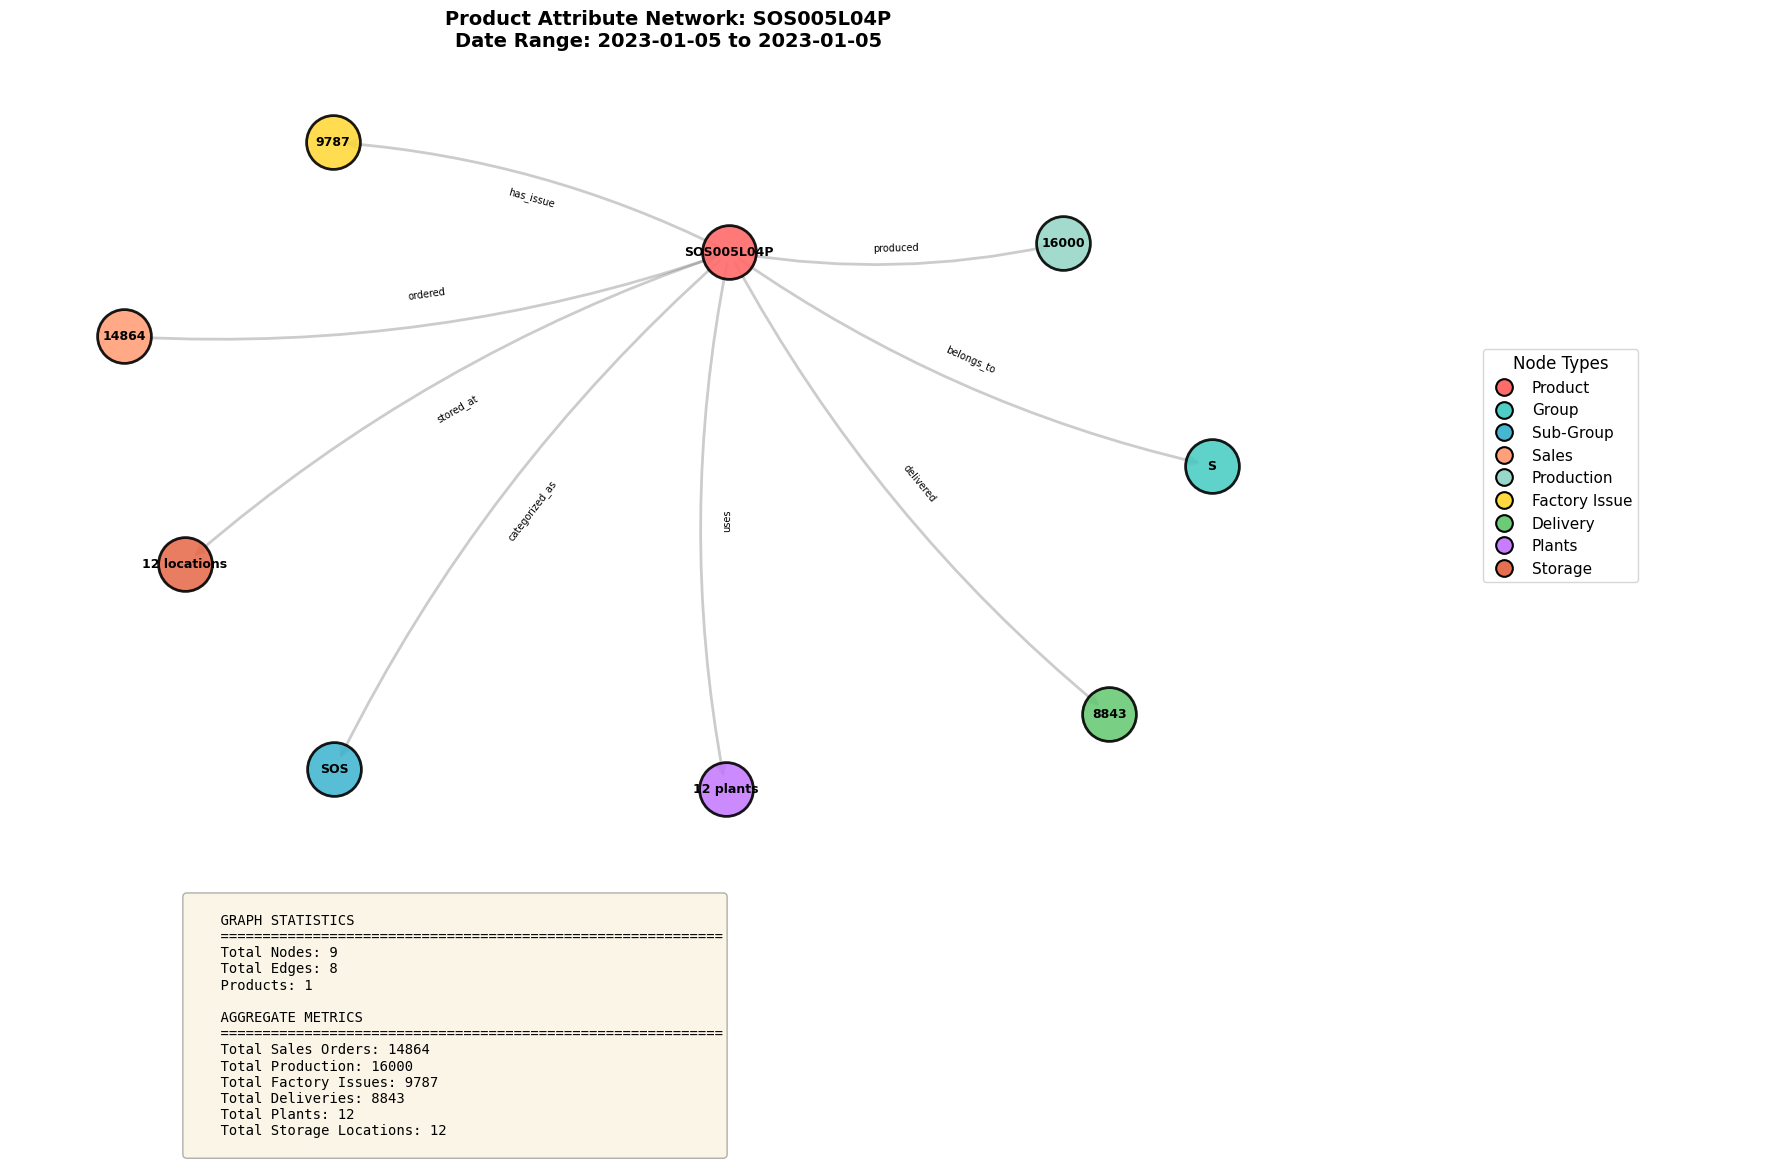


DETAILED PRODUCT INFORMATION

Product: SOS005L04P
  Group: S
  Sub-Group: SOS
  Sales Orders: 14864
  Production: 16000
  Factory Issues: 9787
  Deliveries: 8843
  Number of Plants: 12
  Number of Storage Locations: 12

Example 2: Multiple products, date range


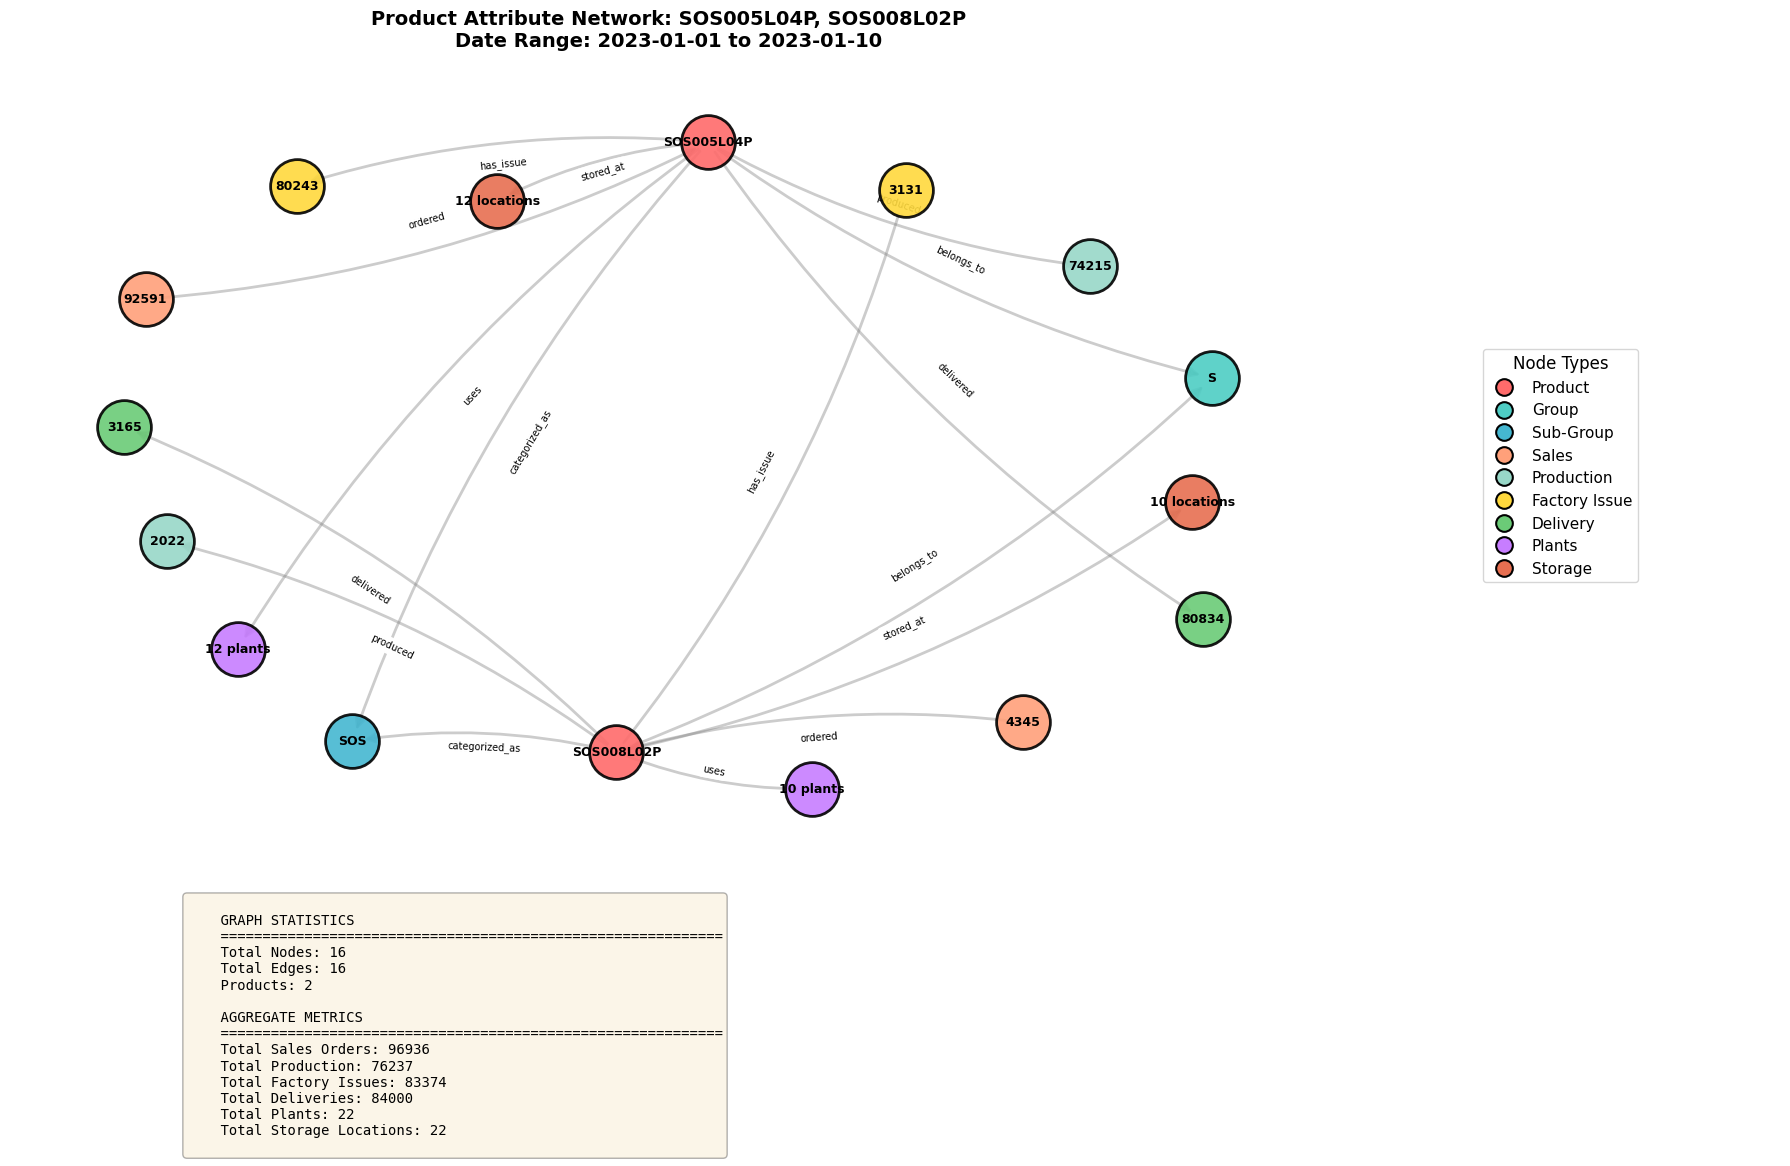


DETAILED PRODUCT INFORMATION

Product: SOS005L04P
  Group: S
  Sub-Group: SOS
  Sales Orders: 92591
  Production: 74215
  Factory Issues: 80243
  Deliveries: 80834
  Number of Plants: 12
  Number of Storage Locations: 12

Product: SOS008L02P
  Group: S
  Sub-Group: SOS
  Sales Orders: 4345
  Production: 2022
  Factory Issues: 3131
  Deliveries: 3165
  Number of Plants: 10
  Number of Storage Locations: 10

Example 3: Single product, all dates


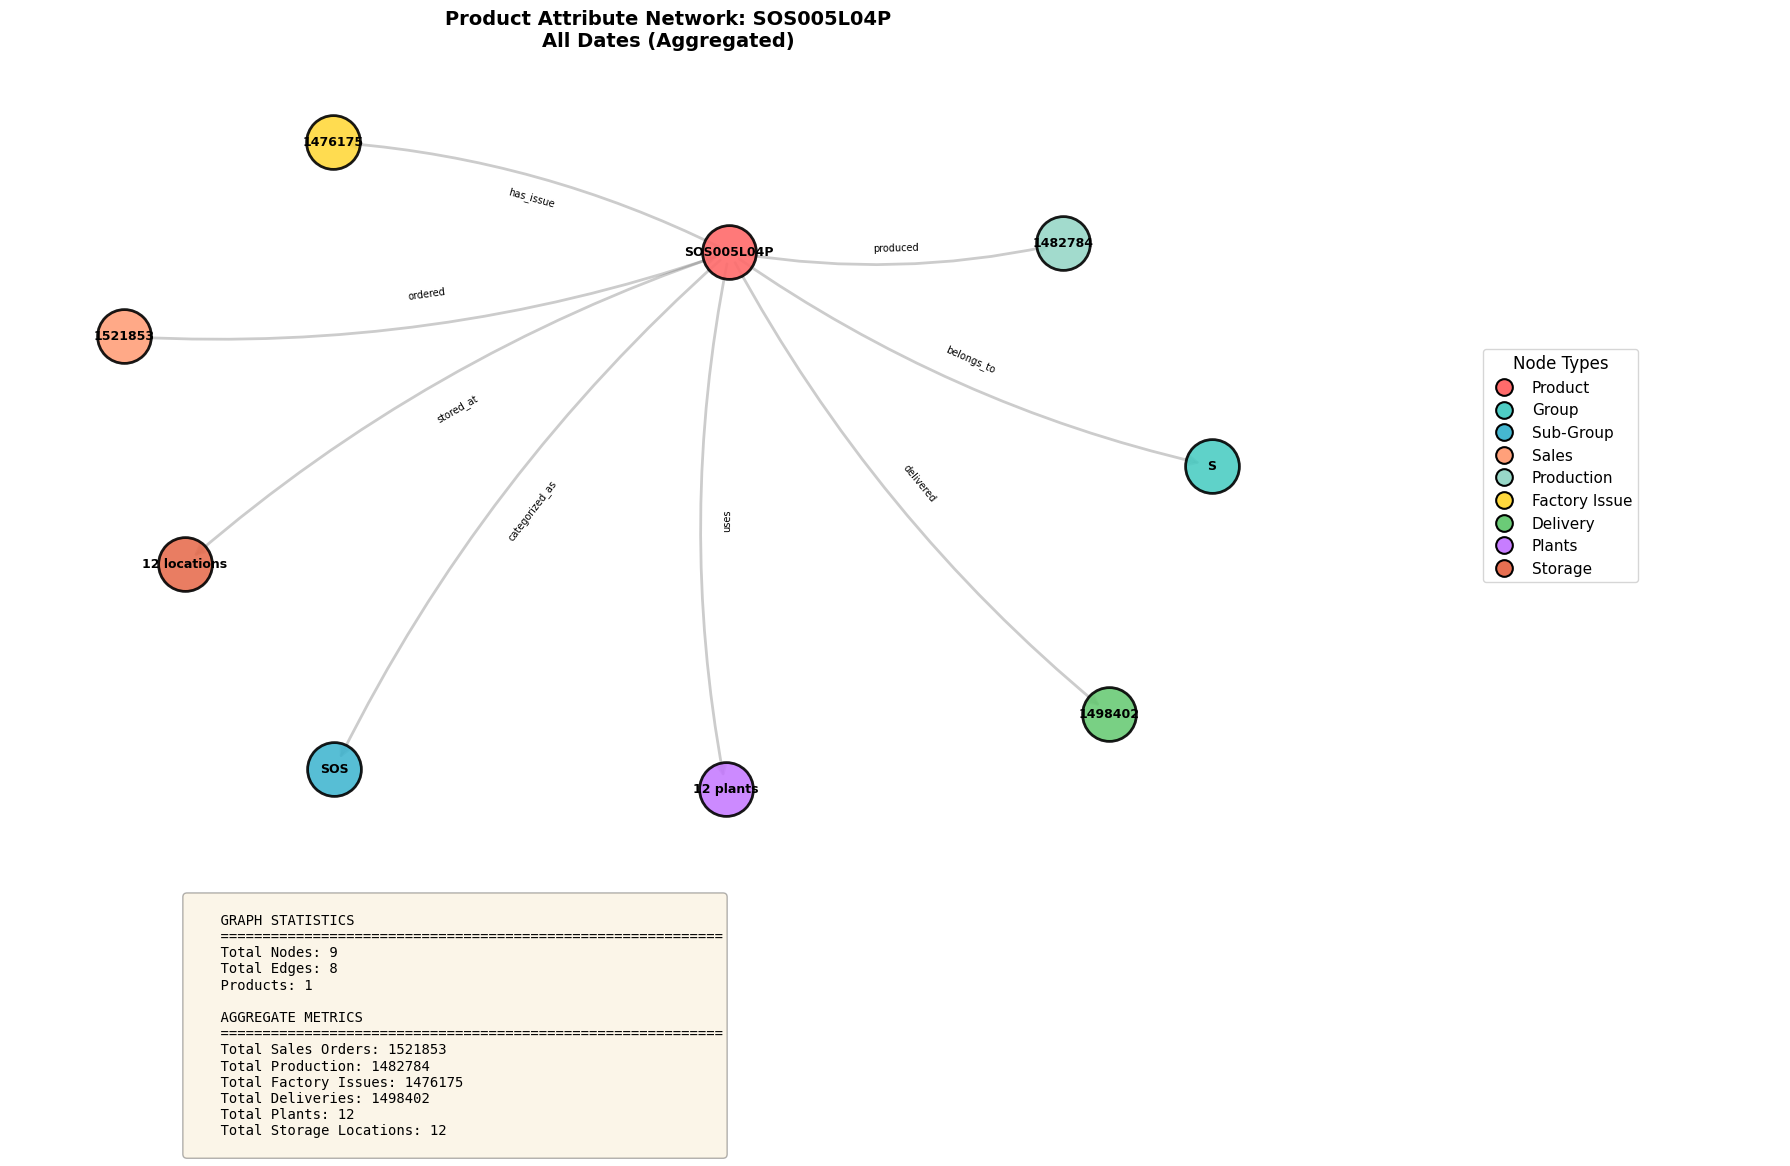


DETAILED PRODUCT INFORMATION

Product: SOS005L04P
  Group: S
  Sub-Group: SOS
  Sales Orders: 1521853
  Production: 1482784
  Factory Issues: 1476175
  Deliveries: 1498402
  Number of Plants: 12
  Number of Storage Locations: 12

Example 4: Three products, specific month


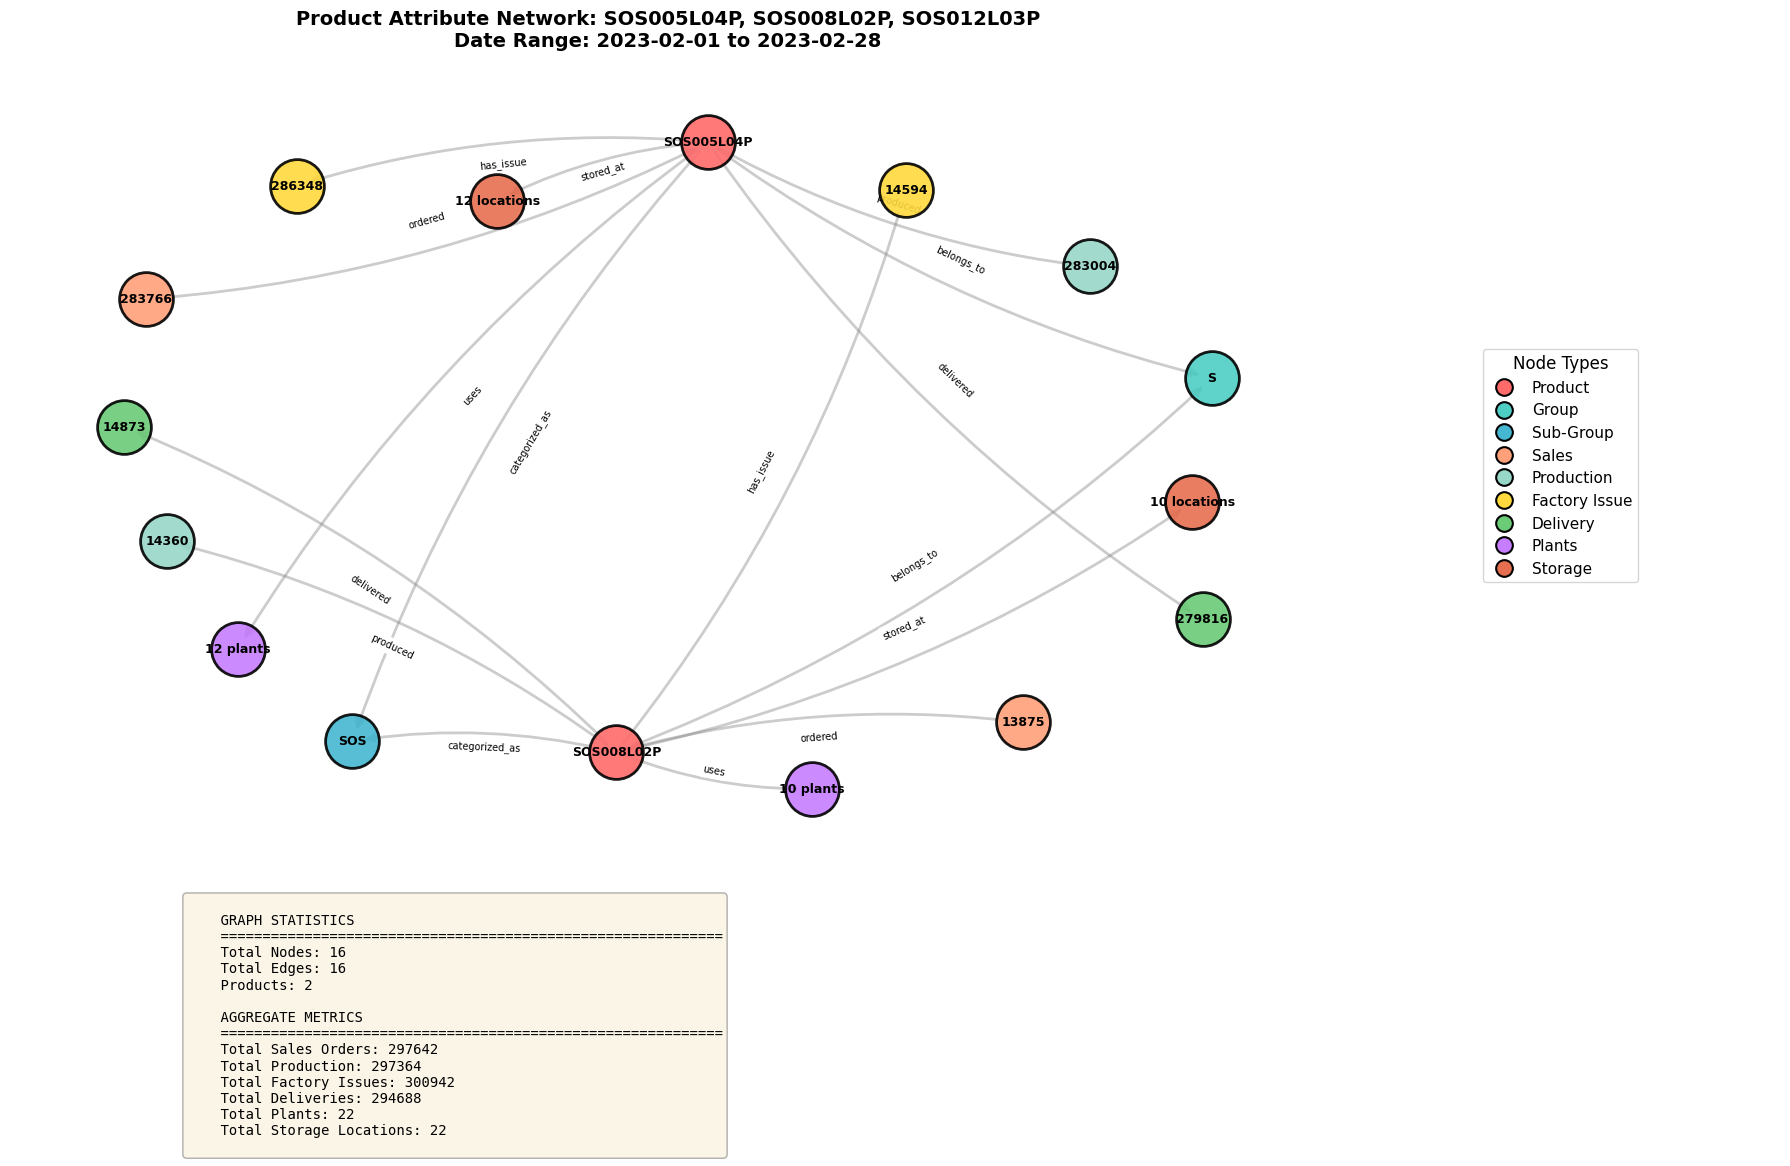


DETAILED PRODUCT INFORMATION

Product: SOS005L04P
  Group: S
  Sub-Group: SOS
  Sales Orders: 283766
  Production: 283004
  Factory Issues: 286348
  Deliveries: 279816
  Number of Plants: 12
  Number of Storage Locations: 12

Product: SOS008L02P
  Group: S
  Sub-Group: SOS
  Sales Orders: 13875
  Production: 14360
  Factory Issues: 14594
  Deliveries: 14873
  Number of Plants: 10
  Number of Storage Locations: 10


In [8]:
def visualize_product_attributes(products, start_date=None, end_date=None, figsize=(18, 12)):
    """
    Visualize product attributes and their relationships as a network graph
    
    Args:
        products: Single product code (str) or list of product codes
        start_date: Start date (str or datetime) or None for no lower bound
        end_date: End date (str or datetime) or None for no upper bound
        figsize: Figure size tuple (width, height)
    
    Returns:
        networkx.DiGraph: The created directed graph object
    
    Examples:
        # Single product, specific date
        G = visualize_product_attributes('SOS005L04P', start_date='2023-01-05', end_date='2023-01-05')
        
        # Multiple products, date range
        G = visualize_product_attributes(['SOS005L04P', 'SOS008L02P'], start_date='2023-01-01', end_date='2023-01-10')
        
        # Single product, all dates
        G = visualize_product_attributes('SOS005L04P')
    """
    
    # Get merged data
    df = merge_product_data(products=products, start_date=start_date, end_date=end_date)
    
    # Aggregate data if multiple dates
    df_agg = df.groupby('Product').agg({
        'Group': 'first',
        'Sub-Group': 'first',
        'sales_order': 'sum',
        'production': 'sum',
        'factory_issue': 'sum',
        'delivery_to_distributor': 'sum',
        'num_plants': 'first',
        'num_storage_locations': 'first'
    }).reset_index()
    
    # Handle NaN values
    df_agg = df_agg.fillna({'Group': 'Unknown', 'Sub-Group': 'Unknown', 
                             'sales_order': 0, 'production': 0, 
                             'factory_issue': 0, 'delivery_to_distributor': 0,
                             'num_plants': 0, 'num_storage_locations': 0})
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Define node types and their colors
    node_colors = {
        'Product': '#FF6B6B',      # Red
        'Group': '#4ECDC4',         # Teal
        'Sub-Group': '#45B7D1',     # Blue
        'Sales': '#FFA07A',         # Light Salmon
        'Production': '#98D8C8',    # Mint
        'Factory Issue': '#FFD93D', # Yellow
        'Delivery': '#6BCB77',      # Green
        'Plants': '#C77DFF',        # Purple
        'Storage': '#E76F51'        # Orange
    }
    
    # Add nodes and edges for each product
    for _, row in df_agg.iterrows():
        product = row['Product']
        
        # Add product node
        G.add_node(product, node_type='Product', label=product)
        
        # Add Group node and edge
        group = str(row['Group'])
        group_node = f"Group: {group}"
        G.add_node(group_node, node_type='Group', label=group)
        G.add_edge(product, group_node, relationship='belongs_to', weight=1)
        
        # Add Sub-Group node and edge
        subgroup = str(row['Sub-Group'])
        subgroup_node = f"SubGroup: {subgroup}"
        G.add_node(subgroup_node, node_type='Sub-Group', label=subgroup)
        G.add_edge(product, subgroup_node, relationship='categorized_as', weight=1)
        
        # Add Sales Order node and edge
        sales = float(row['sales_order'])
        if sales > 0:
            sales_node = f"Sales: {sales:.0f}"
            G.add_node(sales_node, node_type='Sales', label=f"{sales:.0f}", value=sales)
            G.add_edge(sales_node, product, relationship='ordered', weight=1)
        
        # Add Production node and edge
        production = float(row['production'])
        if production > 0:
            prod_node = f"Production: {production:.0f}"
            G.add_node(prod_node, node_type='Production', label=f"{production:.0f}", value=production)
            G.add_edge(product, prod_node, relationship='produced', weight=1)
        
        # Add Factory Issue node and edge
        factory = float(row['factory_issue'])
        if factory > 0:
            factory_node = f"Issue: {factory:.0f}"
            G.add_node(factory_node, node_type='Factory Issue', label=f"{factory:.0f}", value=factory)
            G.add_edge(product, factory_node, relationship='has_issue', weight=1)
        
        # Add Delivery node and edge
        delivery = float(row['delivery_to_distributor'])
        if delivery > 0:
            delivery_node = f"Delivery: {delivery:.0f}"
            G.add_node(delivery_node, node_type='Delivery', label=f"{delivery:.0f}", value=delivery)
            G.add_edge(product, delivery_node, relationship='delivered', weight=1)
        
        # Add Plants node and edge
        plants = int(row['num_plants'])
        if plants > 0:
            plants_node = f"Plants: {plants}"
            G.add_node(plants_node, node_type='Plants', label=f"{plants} plants", value=plants)
            G.add_edge(product, plants_node, relationship='uses', weight=1)
        
        # Add Storage node and edge
        storage = int(row['num_storage_locations'])
        if storage > 0:
            storage_node = f"Storage: {storage}"
            G.add_node(storage_node, node_type='Storage', label=f"{storage} locations", value=storage)
            G.add_edge(product, storage_node, relationship='stored_at', weight=1)
    
    # Create layout
    pos = nx.spring_layout(G, k=3, iterations=50, seed=42)
    
    # Create figure with two subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])
    
    # Main graph plot
    ax_main = fig.add_subplot(gs[0, 0])
    
    # Draw edges with varying widths
    edge_widths = [G[u][v].get('weight', 1) * 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4, 
                          edge_color='gray', arrows=True, 
                          arrowsize=15, ax=ax_main, connectionstyle='arc3,rad=0.1')
    
    # Fixed node size for all nodes
    uniform_node_size = 1500
    
    # Draw nodes by type with uniform size
    for node_type, color in node_colors.items():
        nodes = [n for n in G.nodes() if G.nodes[n].get('node_type') == node_type]
        if nodes:
            nx.draw_networkx_nodes(G, pos, nodelist=nodes, 
                                 node_color=color, node_size=uniform_node_size,
                                 alpha=0.9, edgecolors='black', linewidths=2, ax=ax_main)
    
    # Draw labels
    labels = {node: G.nodes[node].get('label', node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=9, 
                           font_weight='bold', font_color='black', ax=ax_main)
    
    # Edge labels
    edge_labels = {(u, v): G[u][v].get('relationship', '') for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7, ax=ax_main)
    
    # Title
    date_str = ""
    if start_date and end_date:
        date_str = f"\nDate Range: {start_date} to {end_date}"
    elif start_date:
        date_str = f"\nFrom: {start_date}"
    elif end_date:
        date_str = f"\nTo: {end_date}"
    else:
        date_str = "\nAll Dates (Aggregated)"
    
    product_str = products if isinstance(products, str) else ', '.join(products[:3]) + ('...' if len(products) > 3 else '')
    ax_main.set_title(f'Product Attribute Network: {product_str}{date_str}', 
                     fontsize=14, fontweight='bold', pad=20)
    ax_main.axis('off')
    
    # Legend
    ax_legend = fig.add_subplot(gs[0, 1])
    ax_legend.axis('off')
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor=color, markersize=12, 
                   label=node_type, markeredgecolor='black', markeredgewidth=1.5)
        for node_type, color in node_colors.items()
    ]
    ax_legend.legend(handles=legend_elements, loc='center', fontsize=11, 
                    title='Node Types', title_fontsize=12, frameon=True)
    
    # Statistics table
    ax_stats = fig.add_subplot(gs[1, :])
    ax_stats.axis('off')
    
    stats_text = f"""
    GRAPH STATISTICS
    {'='*60}
    Total Nodes: {G.number_of_nodes()}
    Total Edges: {G.number_of_edges()}
    Products: {len(df_agg)}
    
    AGGREGATE METRICS
    {'='*60}
    Total Sales Orders: {df_agg['sales_order'].sum():.0f}
    Total Production: {df_agg['production'].sum():.0f}
    Total Factory Issues: {df_agg['factory_issue'].sum():.0f}
    Total Deliveries: {df_agg['delivery_to_distributor'].sum():.0f}
    Total Plants: {df_agg['num_plants'].sum():.0f}
    Total Storage Locations: {df_agg['num_storage_locations'].sum():.0f}
    """
    
    ax_stats.text(0.1, 0.5, stats_text, fontsize=10, family='monospace', 
                 verticalalignment='center', bbox=dict(boxstyle='round', 
                 facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*80)
    print("DETAILED PRODUCT INFORMATION")
    print("="*80)
    for _, row in df_agg.iterrows():
        print(f"\nProduct: {row['Product']}")
        print(f"  Group: {row['Group']}")
        print(f"  Sub-Group: {row['Sub-Group']}")
        print(f"  Sales Orders: {row['sales_order']:.0f}")
        print(f"  Production: {row['production']:.0f}")
        print(f"  Factory Issues: {row['factory_issue']:.0f}")
        print(f"  Deliveries: {row['delivery_to_distributor']:.0f}")
        print(f"  Number of Plants: {row['num_plants']:.0f}")
        print(f"  Number of Storage Locations: {row['num_storage_locations']:.0f}")
    
    return G


# ========== USAGE EXAMPLES ==========

# Example 1: Single product, specific date
print("\n" + "="*80)
print("Example 1: Single product, specific date")
print("="*80)
G1 = visualize_product_attributes('SOS005L04P', start_date='2023-01-05', end_date='2023-01-05')

# Example 2: Multiple products, date range
print("\n" + "="*80)
print("Example 2: Multiple products, date range")
print("="*80)
G2 = visualize_product_attributes(
    ['SOS005L04P', 'SOS008L02P'], 
    start_date='2023-01-01', 
    end_date='2023-01-10'
)

# Example 3: Single product, all dates (aggregated)
print("\n" + "="*80)
print("Example 3: Single product, all dates")
print("="*80)
G3 = visualize_product_attributes('SOS005L04P')

# Example 4: Three products, specific month
print("\n" + "="*80)
print("Example 4: Three products, specific month")
print("="*80)
G4 = visualize_product_attributes(
    ['SOS005L04P', 'SOS008L02P', 'SOS012L03P'],
    start_date='2023-02-01',
    end_date='2023-02-28'
)

**Why A product group is important in the supply chain process :**

- **Specialization of factories:** The supply chain graph explicitly models connections between products, product groups, and production facilities. Certain factories specialize in particular product groups, creating close associations between product group nodes and facility nodes. As stated: “Boxes represent various product types, with color indicating different groups. They are closely located based on product groups and production facilities. Different relational connections denote shared raw material requirements, interdependence between products, and other impacts” (see Figure 1 and the surrounding explanation on page 2).
- **Exchangeability/specificity of raw materials:** The edges in the supply chain graph also represent “shared raw material requirements” and “interdependence between products.” This means some raw materials may be exchangeable for products within the same group, while others are specific, depending on the group assignment. This is demonstrated by connections between products of the same group, factories, and storage locations.
- **Hierarchical forecasting and optimization:** The dataset is structured to allow for “hierarchy-aware forecasting,” where product groups help organize forecasting and resource allocation, both for demand prediction and factory assignments (see “Dataset Potential and Practical Applications,” page 4).
- **Transfer learning within groups:** In scenarios with limited data, understanding group relationships enables “transfer learning across nodes of the same classification”—meaning models can generalize better for products within the same group (page 4).

**Where in the paper:**
- Directly discussed in relation to the graph structure (Figure 1 explanation and Table 1, page 2), feature descriptions (pages 2–3), and practical applications (page 4).
- The role of product groups in temporal analysis and correlation (pages 3–4).
- Hierarchy-awareness and transfer learning related to product groups (page 4).



<br> <br> <br>



In [19]:
#  Analyze Factory Specialization by Product Group

def analyze_factory_specialization(group=None):
    """
    Analyze which factories specialize in which product groups
    
    Args:
        group: Specific product group to analyze, or None for all groups
    
    Returns:
        pandas.DataFrame: Summary of factory-group relationships
    """
    # Merge product group info with plant/storage info
    product_plant = df_nodes_plant_and_storage.merge(
        df_nodes_productgroup_and_subgroup[['Node', 'Group', 'Sub-Group']],
        on='Node',
        how='left'
    )
    
    # Filter by group if specified
    if group is not None:
        product_plant = product_plant[product_plant['Group'] == group]
    
    # Count products per plant and group
    specialization = product_plant.groupby(['Plant', 'Group']).agg({
        'Node': 'count',
        'Storage Location': 'nunique'
    }).reset_index()
    specialization.columns = ['Plant', 'Group', 'Product_Count', 'Storage_Locations']
    
    # Calculate specialization percentage per plant
    total_per_plant = specialization.groupby('Plant')['Product_Count'].sum().reset_index()
    total_per_plant.columns = ['Plant', 'Total_Products']
    
    specialization = specialization.merge(total_per_plant, on='Plant')
    specialization['Specialization_Percentage'] = (
        specialization['Product_Count'] / specialization['Total_Products'] * 100
    )
    
    # Sort by specialization percentage
    specialization = specialization.sort_values(
        ['Plant', 'Specialization_Percentage'], 
        ascending=[True, False]
    )
    
    print("=" * 80)
    print("FACTORY SPECIALIZATION BY PRODUCT GROUP")
    print("=" * 80)
    
    if group:
        print(f"\nAnalyzing Group: {group}")
    
    # Display summary statistics
    for plant in specialization['Plant'].unique():
        plant_data = specialization[specialization['Plant'] == plant]
        print(f"\n{plant}:")
        print(f"  Total Products: {plant_data['Total_Products'].iloc[0]}")
        print(f"  Product Groups Served: {len(plant_data)}")
        print(f"\n  Group Distribution:")
        for _, row in plant_data.iterrows():
            print(f"    {row['Group']}: {row['Product_Count']} products "
                  f"({row['Specialization_Percentage']:.1f}%) - "
                  f"{row['Storage_Locations']} storage locations")
    
    return specialization



# 1. Factory Specialization
print("\n\n### 1. FACTORY SPECIALIZATION ###")
specialization = analyze_factory_specialization()




### 1. FACTORY SPECIALIZATION ###
FACTORY SPECIALIZATION BY PRODUCT GROUP

1901:
  Total Products: 4
  Product Groups Served: 1

  Group Distribution:
    A: 4 products (100.0%) - 1 storage locations

1903:
  Total Products: 106
  Product Groups Served: 3

  Group Distribution:
    A: 62 products (58.5%) - 1 storage locations
    M: 24 products (22.6%) - 1 storage locations
    S: 20 products (18.9%) - 1 storage locations

1911:
  Total Products: 111
  Product Groups Served: 3

  Group Distribution:
    A: 55 products (49.5%) - 1 storage locations
    M: 48 products (43.2%) - 1 storage locations
    S: 8 products (7.2%) - 1 storage locations

1912:
  Total Products: 198
  Product Groups Served: 3

  Group Distribution:
    A: 144 products (72.7%) - 1 storage locations
    S: 28 products (14.1%) - 1 storage locations
    M: 26 products (13.1%) - 1 storage locations

1914:
  Total Products: 320
  Product Groups Served: 3

  Group Distribution:
    A: 161 products (50.3%) - 1 storage lo

In [36]:
display(df_nodes_plant_and_storage.head())
display(df_nodes_productgroup_and_subgroup.head())
display(df_nodes_plant_and_storage.merge(df_nodes_productgroup_and_subgroup[['Node', 'Group', 'Sub-Group']], on='Node', how='left').head())



,Node,Plant,Storage Location
0,POV002L09P,2120,2030.0
1,SOS001L12P,2120,2030.0
2,POP002L09P,2120,2030.0
3,POP001L12P,2120,2030.0
4,POP001L12P,2120,2030.0


,Node,Group,Sub-Group
0,SOS008L02P,S,SOS
1,SOS005L04P,S,SOS
2,SOS003L04P,S,SOS
3,SOS002L09P,S,SOS
4,SOS001L12P,S,SOS


,Node,Plant,Storage Location,Group,Sub-Group
0,POV002L09P,2120,2030.0,P,POV
1,SOS001L12P,2120,2030.0,S,SOS
2,POP002L09P,2120,2030.0,P,POP
3,POP001L12P,2120,2030.0,P,POP
4,POP001L12P,2120,2030.0,P,POP




### 3. HIERARCHICAL DEMAND PATTERNS ###
HIERARCHICAL DEMAND ANALYSIS

Analysis Period (2023-01-01 to 2023-03-31)
Total Demand: 4,034,023 units
Total Product Groups: 5
Total Products: 41

 PRODUCT GROUPS BY DEMAND

S:
  Total Sales: 2,941,659 units (72.92% of total)
  Total Production: 3,021,408 units
  Products in Group: 14
  Avg Sales per Product: 210,118 units
  Sub-Groups:
    - SOS: 2,851,632 units (96.9%)
    - SE: 79,431 units (2.7%)
    - SOP: 10,514 units (0.4%)

P:
  Total Sales: 562,416 units (13.94% of total)
  Total Production: 575,284 units
  Products in Group: 10
  Avg Sales per Product: 56,242 units
  Sub-Groups:
    - POV: 320,832 units (57.0%)
    - POP: 218,403 units (38.8%)
    - POPF: 23,181 units (4.1%)

A:
  Total Sales: 395,082 units (9.79% of total)
  Total Production: 369,885 units
  Products in Group: 7
  Avg Sales per Product: 56,440 units
  Sub-Groups:
    - ATN: 311,193 units (78.8%)
    - AT: 77,972 units (19.7%)
    - ATWWP: 5,876 units (1.5%)

M:
  Tot

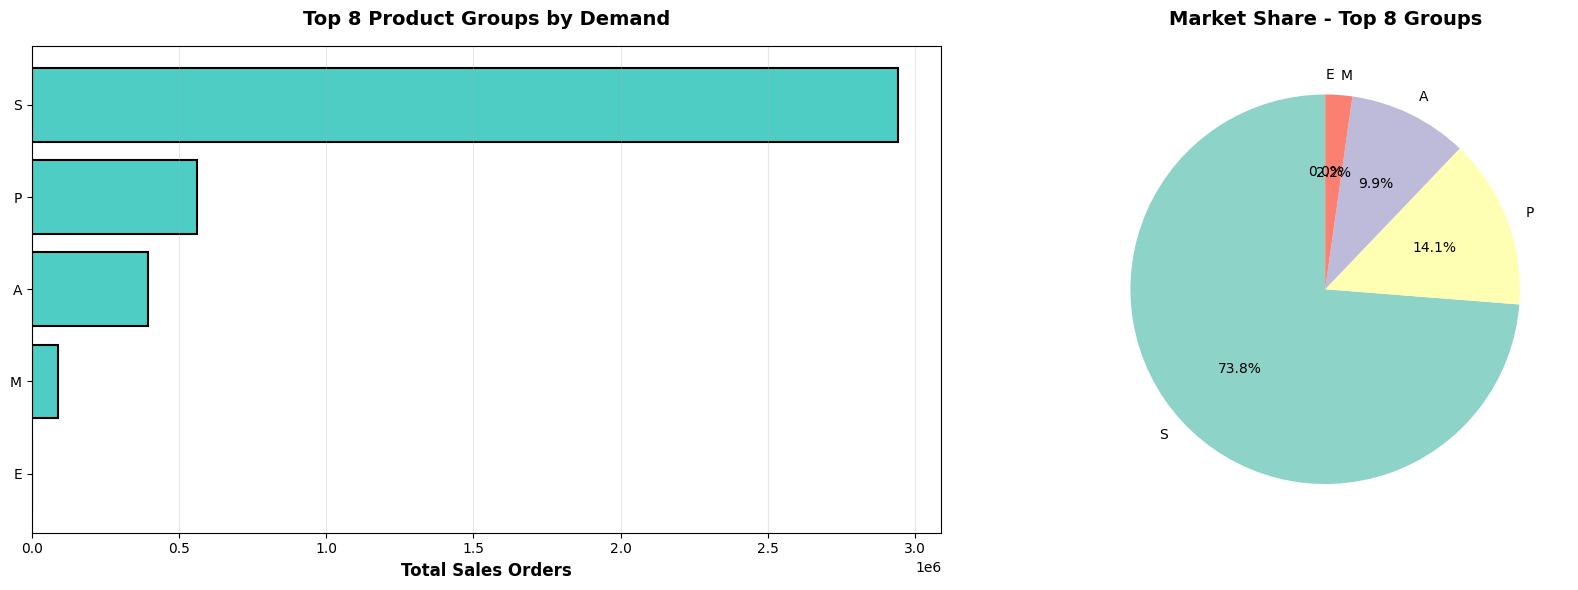

In [26]:
# Hierarchical Demand Analysis

def hierarchical_demand_analysis(start_date=None, end_date=None, top_n_groups=10):
    """
    Analyze demand patterns at different hierarchical levels:
    Total → Product Group → Sub-Group → Individual Product
    
    Args:
        start_date: Start date for analysis
        end_date: End date for analysis
        top_n_groups: Number of top groups to display
    
    Returns:
        dict: Hierarchical demand analysis results
    """
    # Get merged data
    df = merge_product_data(start_date=start_date, end_date=end_date)
    
    # Aggregate by different levels
    total_demand = df['sales_order'].sum()
    
    group_demand = df.groupby('Group').agg({
        'sales_order': 'sum',
        'production': 'sum',
        'Product': 'nunique'
    }).reset_index()
    group_demand.columns = ['Group', 'Total_Sales', 'Total_Production', 'Num_Products']
    group_demand['Avg_Sales_Per_Product'] = group_demand['Total_Sales'] / group_demand['Num_Products']
    group_demand['Group_Percentage'] = (group_demand['Total_Sales'] / total_demand * 100)
    group_demand = group_demand.sort_values('Total_Sales', ascending=False)
    
    subgroup_demand = df.groupby(['Group', 'Sub-Group']).agg({
        'sales_order': 'sum',
        'production': 'sum',
        'Product': 'nunique'
    }).reset_index()
    subgroup_demand.columns = ['Group', 'Sub-Group', 'Total_Sales', 'Total_Production', 'Num_Products']
    
    print("=" * 80)
    print("HIERARCHICAL DEMAND ANALYSIS")
    print("=" * 80)
    
    date_range = ""
    if start_date and end_date:
        date_range = f" ({start_date} to {end_date})"
    elif start_date:
        date_range = f" (from {start_date})"
    elif end_date:
        date_range = f" (to {end_date})"
    
    print(f"\nAnalysis Period{date_range}")
    print(f"Total Demand: {total_demand:,.0f} units")
    print(f"Total Product Groups: {len(group_demand)}")
    print(f"Total Products: {df['Product'].nunique()}")
    
    print(f"\n{'='*80}")
    print(f" PRODUCT GROUPS BY DEMAND")
    print(f"{'='*80}")
    
    for idx, row in group_demand.head(top_n_groups).iterrows():
        print(f"\n{row['Group']}:")
        print(f"  Total Sales: {row['Total_Sales']:,.0f} units ({row['Group_Percentage']:.2f}% of total)")
        print(f"  Total Production: {row['Total_Production']:,.0f} units")
        print(f"  Products in Group: {row['Num_Products']}")
        print(f"  Avg Sales per Product: {row['Avg_Sales_Per_Product']:,.0f} units")
        
        # Show sub-groups
        subgroups = subgroup_demand[subgroup_demand['Group'] == row['Group']].sort_values('Total_Sales', ascending=False)
        if len(subgroups) > 0:
            print(f"  Sub-Groups:")
            for _, sg in subgroups.head(3).iterrows():
                sg_pct = (sg['Total_Sales'] / row['Total_Sales'] * 100)
                print(f"    - {sg['Sub-Group']}: {sg['Total_Sales']:,.0f} units ({sg_pct:.1f}%)")
    
    # Visualization
    visualize_hierarchical_demand(group_demand, top_n_groups)
    
    return {
        'total_demand': total_demand,
        'group_demand': group_demand,
        'subgroup_demand': subgroup_demand
    }


def visualize_hierarchical_demand(group_demand, top_n=10):
    """Visualize hierarchical demand patterns"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Bar chart
    top_groups = group_demand.head(top_n)
    ax1.barh(range(len(top_groups)), top_groups['Total_Sales'], color='#4ECDC4', edgecolor='black', linewidth=1.5)
    ax1.set_yticks(range(len(top_groups)))
    ax1.set_yticklabels(top_groups['Group'])
    ax1.set_xlabel('Total Sales Orders', fontsize=12, fontweight='bold')
    ax1.set_title(f'Top {top_n} Product Groups by Demand', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()
    
    # Pie chart
    ax2.pie(top_groups['Total_Sales'], labels=top_groups['Group'], autopct='%1.1f%%',
            startangle=90, colors=plt.cm.Set3(range(len(top_groups))))
    ax2.set_title(f'Market Share - Top {top_n} Groups', fontsize=14, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()

# 3. Hierarchical Forecasting
print("\n\n### 3. HIERARCHICAL DEMAND PATTERNS ###")
hierarchy = hierarchical_demand_analysis(
    start_date='2023-01-01',
    end_date='2023-03-31',
    top_n_groups=8
)

do the store locations relate to production sites or are completely independent? shall we model the relationship between a product and store location indirectly?

In [37]:
df_nodes_plant_and_storage

,Node,Plant,Storage Location
0,POV002L09P,2120,2030.0
1,SOS001L12P,2120,2030.0
2,POP002L09P,2120,2030.0
3,POP001L12P,2120,2030.0
4,POP001L12P,2120,2030.0
...,...,...,...
6540,MAC1K25P,1915,1530.0
6541,EEA500G12P,2120,2030.0
6542,EEA200G24P,2120,2030.0
6543,EEA500G12P,1920,1130.0


In [48]:
def get_storage_locations_by_plant(plant, unique=True, dropna=True, return_df=False):
    """
    Return storage location(s) for a given plant id (or list of plant ids).
    
    Args:
        plant: int, str, or list[int/str] - one plant id or a list of plant ids
        unique: bool - return unique storage locations (list) if True,
                       otherwise return a dataframe with all matched rows
        dropna: bool - drop NaN storage locations
        return_df: bool - always return a pandas.DataFrame (overrides unique)
    
    Returns:
        list or pandas.DataFrame:
            - If return_df is True: returns DataFrame with columns ['Node', 'Plant', 'Storage Location'] filtered by plant
            - Else if unique is True: returns list of unique storage locations
            - Else: returns pandas.DataFrame with matched rows (may contain duplicates)
    
    Examples:
        get_storage_locations_by_plant(2120)
        get_storage_locations_by_plant([2120, 2121], unique=False)
        get_storage_locations_by_plant('2120', dropna=False, return_df=True)
    """
    # Normalize plant(s) into list
    if isinstance(plant, (int, str)):
        plant_vals = [int(plant)] if str(plant).isdigit() else [plant]
    elif hasattr(plant, "__iter__"):
        plant_vals = [int(p) if str(p).isdigit() else p for p in plant]
    else:
        raise TypeError("plant must be int, str, or iterable of ints/strs")
    
    # Filter global dataframe
    df_filtered = df_nodes_plant_and_storage[df_nodes_plant_and_storage['Plant'].isin(plant_vals)].copy()
    
    if dropna:
        df_filtered = df_filtered.dropna(subset=['Storage Location'])
    
    if return_df:
        # Return full DataFrame (copy to avoid side-effects)
        return df_filtered.reset_index(drop=True)
    
    if unique:
        # Return unique storage locations as a sorted list
        storages = df_filtered['Storage Location'].unique().tolist()
        storages = [s for s in storages if not (pd.isna(s))]
        try:
            # sort numerically if numeric
            storages = sorted(storages)
        except Exception:
            pass
        return storages
    
    return df_filtered.reset_index(drop=True)



get_storage_locations_by_plant(1917)
# get_storage_locations_by_plant([2120, 2121], unique=False)
# get_storage_locations_by_plant('2120', dropna=False, return_df=True) # dropna 

[1730.0]

In [44]:
df_nodes_plant_and_storage["Plant"].value_counts()

Plant
2103    790
2114    632
2112    539
2115    485
2119    376
2117    374
2120    364
2121    323
1914    320
2111    300
2118    290
2116    263
1915    198
1912    198
1920    168
1921    159
2122    143
1916    111
1911    111
1903    106
1922     97
1918     79
1919     64
1917     51
1901      4
Name: count, dtype: int64

In [49]:
# ...existing code...
def storage_to_plant_summary():
    """Check whether storage locations are tied to a single plant or shared across many."""
    df = df_nodes_plant_and_storage.dropna(subset=['Storage Location'])
    s2p = df.groupby('Storage Location')['Plant'].nunique().reset_index(name='num_plants')
    print("Storage locations associated with multiple plants:", (s2p['num_plants'] > 1).sum())
    display(s2p.sort_values('num_plants', ascending=False).head(10))
    return s2p

def build_product_plant_storage_graph(products=None, add_direct_storage_edges=False):
    """Build nx.Graph with Product -> Plant and Plant -> Storage edges.
       If add_direct_storage_edges=True, also add Product -> Storage edges.
    """
    # select products (all if None)
    if products is None:
        products = df_nodes_plant_and_storage['Node'].unique().tolist()

    G = nx.DiGraph()
    # add plants and storage as nodes from master mapping
    mapping = df_nodes_plant_and_storage.dropna(subset=['Plant']).copy()
    mapping['PlantNode'] = mapping['Plant'].astype(str).apply(lambda x: f"Plant:{x}")
    mapping['StorageNode'] = mapping['Storage Location'].fillna('').astype(str).apply(lambda x: f"Storage:{x}" if x else "")
    
    # add Plant -> Storage edges
    plant_storage = mapping[['PlantNode', 'StorageNode']].drop_duplicates()
    for _, r in plant_storage.iterrows():
        if r['StorageNode']:
            G.add_node(r['PlantNode'], node_type='Plant')
            G.add_node(r['StorageNode'], node_type='Storage')
            G.add_edge(r['PlantNode'], r['StorageNode'], relationship='has_storage')

    # add product -> plant edges (product produced at plant)
    prod_plant = mapping[['Node', 'PlantNode']].drop_duplicates()
    for _, r in prod_plant.iterrows():
        G.add_node(r['Node'], node_type='Product')
        G.add_node(r['PlantNode'], node_type='Plant')
        G.add_edge(r['Node'], r['PlantNode'], relationship='produced_at')

    # optional direct product -> storage edges
    if add_direct_storage_edges:
        prod_storage = mapping[['Node', 'StorageNode']].drop_duplicates()
        for _, r in prod_storage.iterrows():
            if r['StorageNode']:
                G.add_node(r['Node'], node_type='Product')
                G.add_node(r['StorageNode'], node_type='Storage')
                G.add_edge(r['Node'], r['StorageNode'], relationship='stored_at')

    return G

# ...existing code...
# Quick checks
s2p = storage_to_plant_summary()
G = build_product_plant_storage_graph(products=['SOS005L04P'], add_direct_storage_edges=True)
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

Storage locations associated with multiple plants: 12


,Storage Location,num_plants
2,1130.0,3
3,1230.0,2
1,330.0,2
4,1430.0,2
5,1530.0,2
9,1930.0,2
6,1630.0,2
7,1730.0,2
8,1830.0,2
11,2130.0,2


Nodes: 78 Edges: 578
